In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap
from datetime import datetime

In [2]:
# Fetch Data
ticker = 'BAJAJ-AUTO.NS'
start_date = '2019-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
df = yf.download(ticker, start=start_date, end=end_date)
df = df[['Close', 'Open', 'High', 'Low', 'Volume']]
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = scaler.fit_transform(df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Split Data
train_size = int(len(df) * 0.897)
train = df.iloc[:train_size].copy()
valid = df.iloc[train_size:].copy()

In [4]:
# Prepare Sequences
def create_sequences(data, seq_length=10):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

seq_length = 10
sequences = create_sequences(df_scaled, seq_length + 1)
train_data, test_data = train_test_split(sequences, test_size=0.2, shuffle=False)
val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)

X_train, y_train = train_data[:, :-1, :], train_data[:, -1, 0]
X_valid, y_valid = val_data[:, :-1, :], val_data[:, -1, 0]
X_test, y_test = test_data[:, :-1, :], test_data[:, -1, 0]

In [5]:
# LSTM Model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False,activation='relu'),
    Dense(32,activation='relu'),
    BatchNormalization(),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=110, restore_best_weights=True)

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.4211 - mean_squared_error: 0.4211 - val_loss: 0.3565 - val_mean_squared_error: 0.3565
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0977 - mean_squared_error: 0.0977 - val_loss: 0.7689 - val_mean_squared_error: 0.7689
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.9268 - val_mean_squared_error: 0.9268
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.8961 - val_mean_squared_error: 0.8961
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.8658 - val_mean_squared_error: 0.8658
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.8318 - val_mean_squared_error: 0.8318
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.8265 - v

In [7]:
lstm_predictions = lstm_model.predict(X_test).reshape(-1, 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [8]:
# XGBoost Model
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.2)

In [9]:
xgb_model.fit(X_train_xgb, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
xgb_predictions = xgb_model.predict(X_test_xgb).reshape(-1, 1)

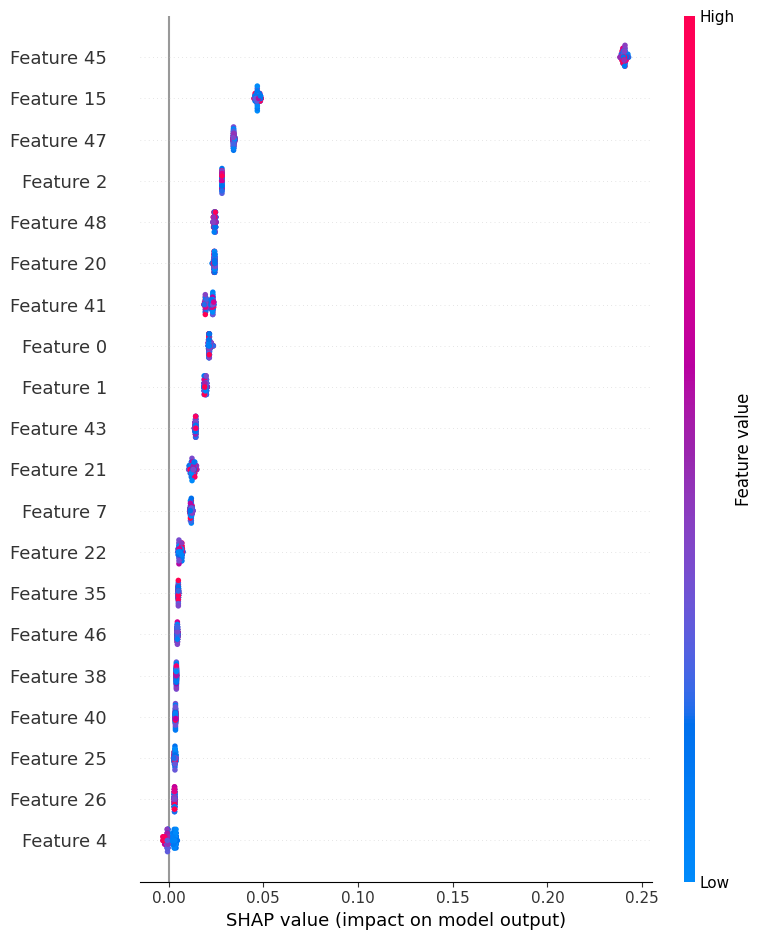

In [11]:
# SHAP Analysis
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_xgb)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_xgb)

In [12]:
# Ensemble Model
ensemble_predictions = (lstm_predictions + xgb_predictions) / 2

In [13]:
# Rescale Predictions
def inverse_transform(predictions, scaler):
    return scaler.inverse_transform(np.hstack((predictions, np.zeros((len(predictions), 4)))))[:, 0]

y_test_unscaled = inverse_transform(y_test.reshape(-1, 1), scaler)
lstm_predictions = inverse_transform(lstm_predictions, scaler)
xgb_predictions = inverse_transform(xgb_predictions, scaler)
ensemble_predictions = inverse_transform(ensemble_predictions, scaler)

In [14]:
# Add Predictions to Validation Data
valid = valid.iloc[-len(lstm_predictions):].copy()
valid['LSTM Predictions'] = lstm_predictions
valid['XGBoost Predictions'] = xgb_predictions
valid['Ensemble Predictions'] = ensemble_predictions
valid.index = df.index[train_size:][-len(valid):]
valid = valid.interpolate()
train.index = df.index[:train_size]

# Model Evaluation
def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R^2': r2_score(y_true, y_pred)
    }

metrics = {
    'LSTM': evaluate_model(y_test_unscaled, lstm_predictions),
    'XGBoost': evaluate_model(y_test_unscaled, xgb_predictions),
    'Ensemble': evaluate_model(y_test_unscaled, ensemble_predictions)
}
pd.DataFrame(metrics).T

,MAE,MSE,RMSE,R^2
LSTM,542.393557,5.064393e+05,711.645512,0.692616
XGBoost,3406.292686,1.326310e+07,3641.853895,-7.050057
Ensemble,1441.793901,2.401210e+06,1549.583892,-0.457418


In [15]:
print(train.index.shape)
print(train['Close'].shape)
print(train.head())

(1375,)
(1375, 1)
Price              Close          Open          High           Low  \
Ticker     BAJAJ-AUTO.NS BAJAJ-AUTO.NS BAJAJ-AUTO.NS BAJAJ-AUTO.NS   
Date                                                                 
2019-01-01   2288.534180   2295.542591   2302.592804   2270.362965   
2019-01-02   2259.451904   2282.952890   2305.824385   2246.862091   
2019-01-03   2267.299805   2257.857444   2286.184527   2251.142876   
2019-01-04   2294.871338   2277.917095   2301.418082   2267.929258   
2019-01-07   2231.376709   2299.655344   2299.739358   2220.003869   

Price             Volume  
Ticker     BAJAJ-AUTO.NS  
Date                      
2019-01-01        304150  
2019-01-02        599274  
2019-01-03        310511  
2019-01-04        362393  
2019-01-07        462215  


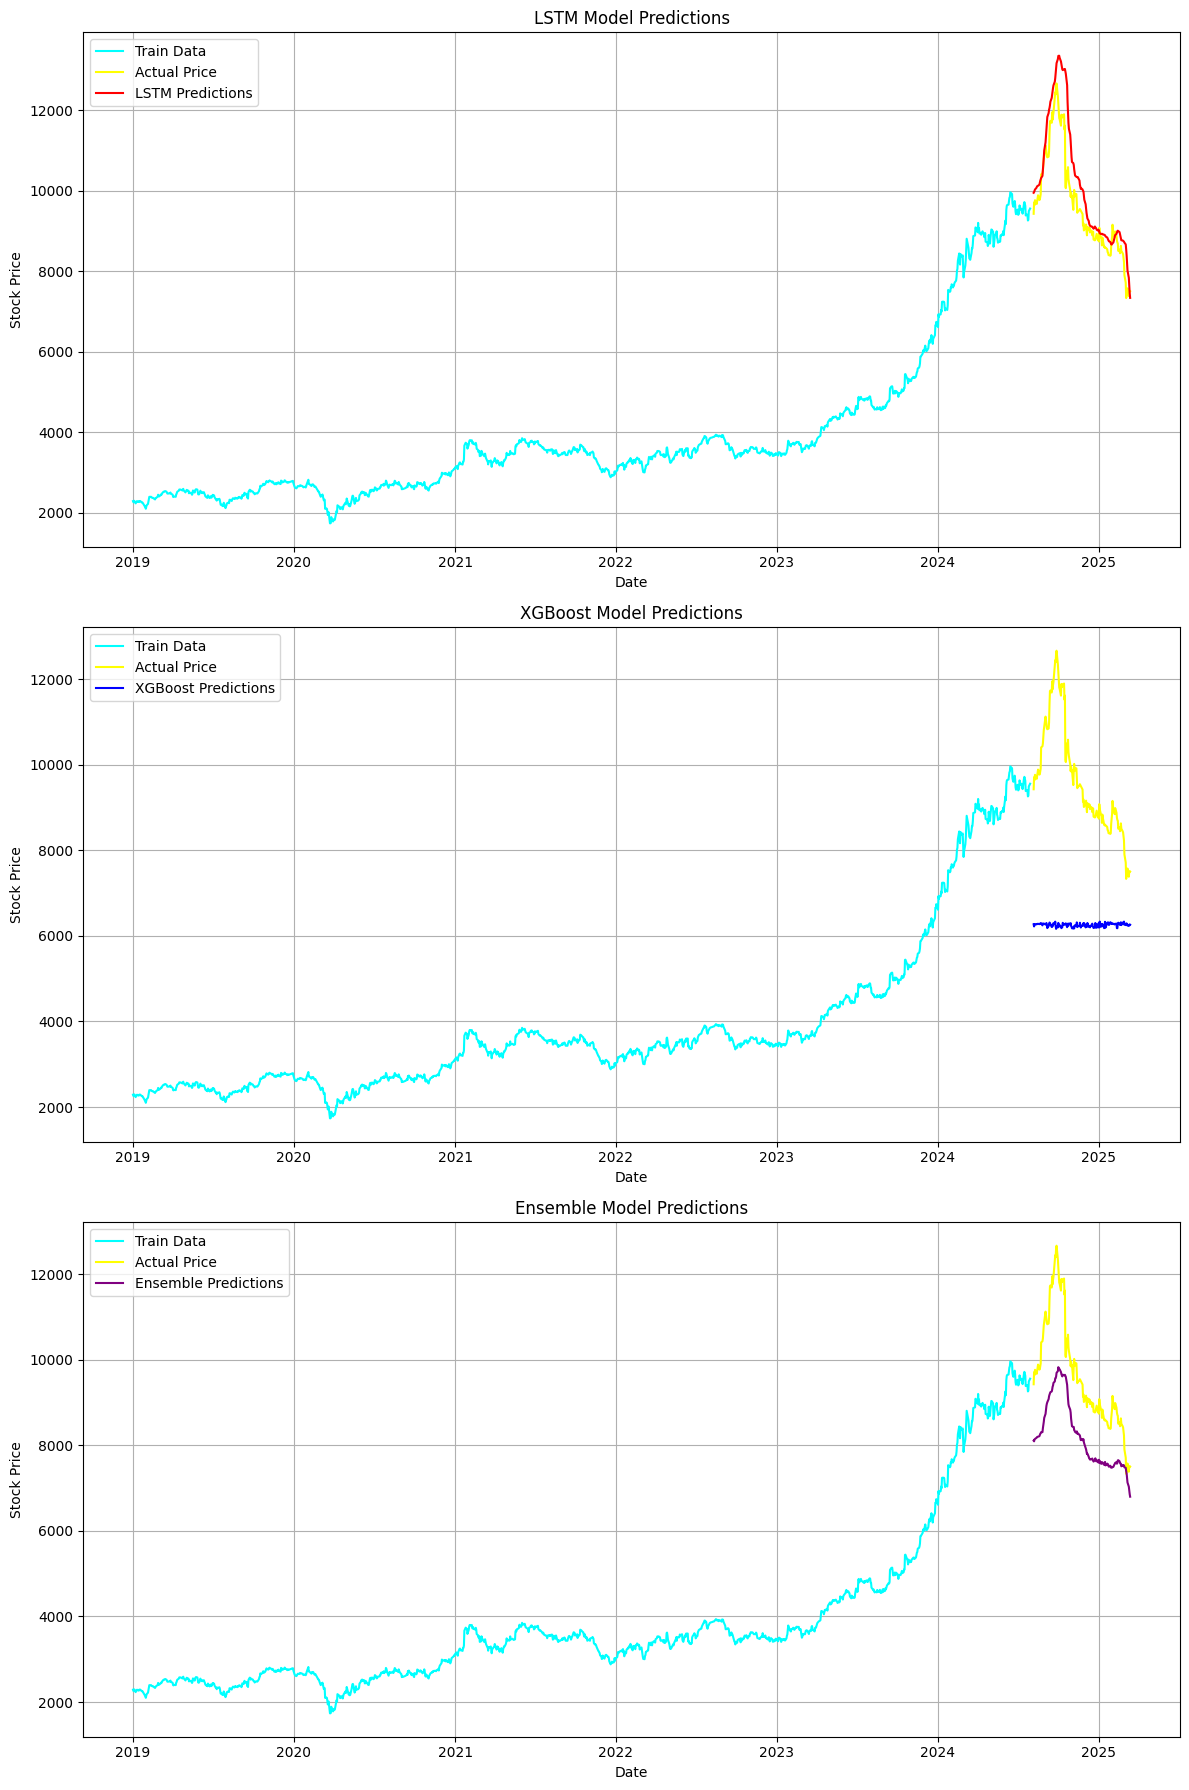

: 

In [ ]:
# Subplots for Predictions
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
models = ['LSTM Predictions', 'XGBoost Predictions', 'Ensemble Predictions']
colors = ['red', 'blue', 'purple']

titles = ['LSTM Model Predictions', 'XGBoost Model Predictions', 'Ensemble Model Predictions']
for i, model in enumerate(models):
    sns.lineplot(x=train.index, y=train['Close'].squeeze(), label='Train Data', color='cyan', ax=axes[i])
    sns.lineplot(x=valid.index, y=valid['Close'].squeeze(), label='Actual Price', color='yellow', ax=axes[i])
    sns.lineplot(x=valid.index, y=valid[model], label=model, color=colors[i], ax=axes[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Stock Price')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()